<center>Заметка 9.а Метод RANSAC</center>
<center>курса <q>Введение в цифровую обработку изображений</q>.</center>
<center>Шокуров Антон В.</center>
<center>shokurov.anton.v@yandex.ru</center>
<center>http://машинноезрение.рф</center>
<center>Версия 0.09</center>

<center>Аннотация</center>
<p>
...
</p>

<p>Это предварительная версия! Любые замечания приветствуются.</p>

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as plot3d
import cv2 as cv
from matplotlib import cm
from matplotlib.ticker import MaxNLocator
import scipy.stats as stats
import scipy.spatial.transform as transform

In [ ]:
# Для точной повторяемости некоторых из результатов.
# для совместимости: np.random.seed(2021)
rng = np.random.default_rng(2021)

In [16]:
#rng?
rng.standard_normal()
# Должно быть -0.06886119500819549

-0.06886119500819549

<h2>RANSAC (RANdom SAmple Consensus)</h2>

<span style="color:green"> Для перехода от одной камеры к другой используется
матрица проективной геометрии. Но система у нас неидеальная, так как решаем прикладную задачу. Во входных данных могут быть ошибки, которые обычно носят характер шума. Помимо шума бывают ошибки разметки. Алгоритм, сопоставляющий точки на изображениях (см. предыдущую лекцию), может сдать сбой. При этом могут появиться явные выбросы. 
    Скажем, что наша
модель задается конечным набором точек (размеченные точки).
Будем многократно делать следующее: случайно выбирать 5 точек, строить модель, проходить по оставшимся точкам и проверять сколько из них правильные (правильные переходы) согласно данной вычисленной модели. 
Выводы теории вероятностей гарантируют, что на некоторой итерации с вероятностью выше 95% правильная модель найдется.
</span>

<span style="color:green">
    Рассмотрим конкретные примеры.
</span>

<h3>Поиск прямой/отрезка</h3>

<span style="color:green"> 
     Как найти 2 прямые, проходящие через заданные
случайные точки? Регрессия не подходит.
    Используем подход RANSAC.
</span>

<b>Построим точки принадлежащие отрезку</b>

Случайно, равномерно, выберем точки на отрезке 0 до 10.

In [17]:
r1 = rng.random(50)*10 # np.random.rand(50)
r2 = rng.random(50)*10 # np.random.rand(50)

Вторая координата этих точек пусть пока будет равна 0.

In [18]:
l1 = np.zeros( 50 )
l2 = np.zeros( 50 )

In [20]:
l1.shape, r1.shape

((50,), (50,))

Совместим порознь созданные массивы в один, из двумерных точек.

In [21]:
l1 = np.dstack( (l1, r1) )[0];
l2 = np.dstack( (r2, l2) )[0]; # Внимание, тут другой порядок!

In [22]:
l1[:,0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [23]:
l1[:,1]

array([9.41381866, 5.92463035, 3.18841713, 6.26073838, 0.35513868,
       2.52126959, 4.8501366 , 3.01266885, 7.21950943, 9.29890659,
       9.08235809, 0.84958562, 2.70366174, 9.71681756, 2.60150065,
       8.00520309, 7.98278648, 6.42569202, 6.68068645, 2.35213149,
       0.21905757, 1.29611448, 1.22984062, 4.5408739 , 4.77345172,
       6.66925043, 8.00727164, 4.20698219, 1.14452255, 2.56178772,
       4.89951786, 0.85282708, 7.16763097, 3.31003791, 6.10183378,
       5.9819869 , 8.25499854, 8.86270018, 8.50226321, 5.27954707,
       4.60578181, 0.24666482, 9.34994129, 3.36405683, 1.32582635,
       1.96672423, 3.61211198, 2.33376858, 1.52311374, 4.26677686])

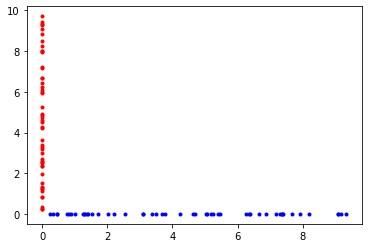

In [24]:
plt.plot( l1[:,0], l1[:,1], "r." )
plt.plot( l2[:,0], l2[:,1], "b." );

<span style="color:green">
Это правильный ответ (искомые прямые раскрашены).
</span>

<b>Поиск идеально заданных орезков</b>

Нужно найти эти прямые.

Как будем действовать. 
<span style="color:green">Прямая задается 2 точками.
</span>
Берем пару случайных точек.
Мы имеем два случая:
а) нам повезло и они принадлежат одной прямой
б) они принадлежат разным прямым.

Как понять какой случай у нас?
Очевидно по "поддержке".
Так, строим прямую через эти две точки и смотрим сколько точек находятся от ней на расстоянии эпсилон.
Если точек много, то эти две точки принадлежат одной прямой.

In [25]:
# объединим два массива точек в один.
ll = np.vstack( (l1, l2) )

In [26]:
ll.shape

(100, 2)

Вот в таком наборе точек нужно найти отрезок.

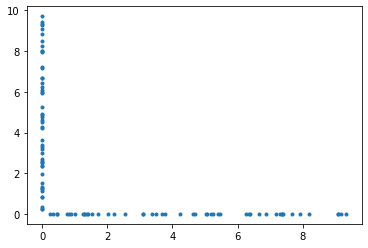

In [27]:
plt.plot( ll[:,0], ll[:,1], "." );

<b>Прямая через две точки</b>

Построим прямую проходящую через две точки.

In [28]:
p1 = ll[40]
p2 = ll[70]

p1, p2

(array([0.        , 4.60578181]), array([7.17196323, 0.        ]))

In [29]:
d = p2 - p1
d

array([ 7.17196323, -4.60578181])

Будем использовать параметрическое задание отрезка/прямой.

In [16]:
t = np.linspace( 0, 1, 50 )

In [17]:
p = np.outer(t, d) + p1
p.shape

(50, 2)

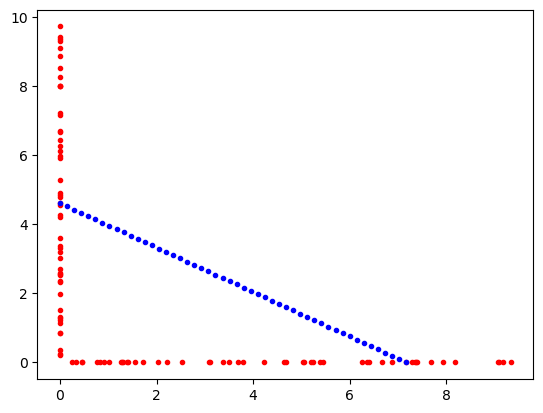

In [18]:
plt.plot( ll[:,0], ll[:,1], "r." )
plt.plot( p[:,0], p[:,1], "b." );

<span style="color:green"> 
Здесь мы попали в случай б)
</span>

<b>Зададим уравнение прямой</b>

Найдем уравнение в виде ax+by+c=0

In [19]:
p3 = ll[55]
p3

array([9.34200581, 0.        ])

In [20]:
# 0 -- x
# 1 -- y
a = p2[1] - p1[1]
b = p1[0] - p2[0]
c = -(a*p2[0] + b*p2[1])
"Уравнение прямой {}*x + {}*y + {} = 0".format( a, b, c )

'Уравнение прямой -4.605781807763664*x + -7.171963228874198*y + 33.03249776549873 = 0'

Проверим что проходит через выбранные точки.

In [21]:
a*p2[0] + b*p2[1] + c, a*p1[0] + b*p1[1] + c

(0.0, 0.0)

<b>Найдем расстояние от точки до прямой</b>

Известна формула для поиска расстояния от точки до прямой заданное отмеченым ранее уравнением.

In [22]:
(a*p3[0] + b*p3[1] + c)/(np.sqrt(a**2 + b**2))

-1.1726082934117088

Итого, более коротко так.

In [23]:
np.cross(p2-p1,p3-p1)/np.linalg.norm(p2-p1)

1.1726082934117088

In [24]:
# Расстояние до прямой для каждой из точек.
dd = np.abs( np.cross(p2-p1,ll-p1)/np.linalg.norm(p2-p1) )
dd[10:20]

array([3.7667378 , 3.1605864 , 1.60050608, 4.30059276, 1.68646776,
       2.86038432, 2.84152225, 1.53133201, 1.74589267, 1.89629514])

In [25]:
# Количество точек на расстоянии 0.1
np.sum( dd < 0.1 )

4

<span style="color:green"> 
Теперь переберем 50 пар точек в цикле, сохраним индексы (\(jj1, jj2\)) тех точек,
 через которые проходит прямая с максимальной "поддержкой" \(m\).
</span>

In [26]:
m = 0
jj1 = 0
jj2 = 0
for _ in range(50):
    ii1 = rng.integers( ll.shape[0] ) #np.random.randint( ll.shape[0] ) 
    ii2 = rng.integers( ll.shape[0] ) #np.random.randint( ll.shape[0] ) 
    p1 = ll[ ii1 ]
    p2 = ll[ ii2 ]
    v = np.linalg.norm(p2-p1)
    # Если точки совпали, то выбираем другую пару.
    if v == 0:
        continue
    dd = np.abs( np.cross(p2-p1,ll-p1)/v )
    cnt = np.sum( dd < 0.1 )
    if cnt > m:
        jj1 = ii1
        jj2 = ii2
        m = cnt

In [27]:
print(jj1, jj2, m)

27 22 50


In [28]:
p1 = ll[jj1]
p2 = ll[jj2]
d = p2 - p1
p = np.outer(t,d) + p1

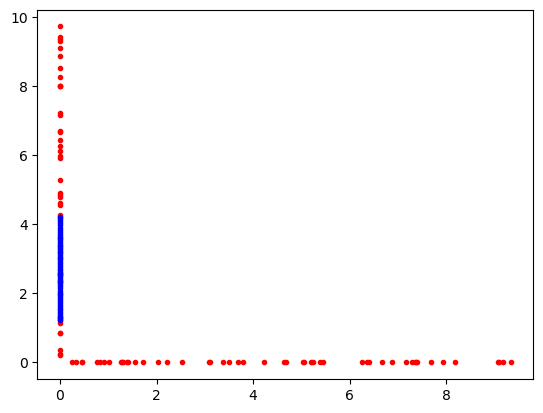

In [29]:
plt.plot( ll[:,0], ll[:,1], "r." )
plt.plot( p[:,0], p[:,1], "b." );

<span style="color:green"> 
   Здесь изображен отрезок между 2 найденными точками.
   Он относится к одной из искомых прямых, 
   то есть мы нашли правильное множество точек.
</span>

<span style="color:green"> 
Вынесем приведенный выше код в отдельную функцию:
</span>

In [30]:
def search_4_line(ll, dist = 0.02):
    m = 0
    jj1 = 0
    jj2 = 0
    d = 0

    for _ in range(50):
        ii1 = rng.integers( ll.shape[0] ) #np.random.randint( ll.shape[0] ) 
        ii2 = rng.integers( ll.shape[0] ) #np.random.randint( ll.shape[0] ) 
        p1 = ll[ ii1 ]
        p2 = ll[ ii2 ]
        v = np.linalg.norm(p2-p1)
        if v==0:
            continue

        dd = np.abs( np.cross(p2-p1,ll-p1)/v )
        cnt = np.sum( dd < dist )
        if (cnt > m) or ( cnt == m and v > d ):
            jj1 = ii1
            jj2 = ii2
            m = cnt
            d = v
    return jj1, jj2

In [31]:
jj1, jj2 = search_4_line( ll )

In [32]:
p1 = ll[jj1]
p2 = ll[jj2]
d = p2 - p1
p = np.outer(t,d) + p1

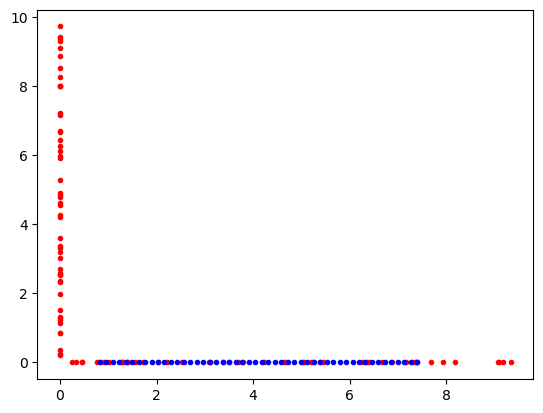

In [33]:
plt.plot( ll[:,0], ll[:,1], "r." )
plt.plot( p[:,0], p[:,1], "b." );

Ищем две самые удаленные точки <span style="color:green"> одной из искомых прямых.
</span>

In [34]:
def refine_points( ll, jj1, jj2, dist = 0.02):
    p1 = ll[jj1]
    p2 = ll[jj2]
    v = np.linalg.norm(p2-p1)
    for i in range(ll.shape[0]):
        p = ll[i]
        dis = np.abs( np.cross(p2-p1,p-p1)/np.linalg.norm(p2-p1) )
        if dis > dist:
            continue
        v1 = np.linalg.norm(p-p1)
        v2 = np.linalg.norm(p-p2)
        if v1 > v:
            jj2 = i
            p2 = p
        elif v2>v:
            jj1 = i
            p1 = p
    return jj1, jj2

In [35]:
jj1, jj2 = refine_points( ll, jj1, jj2)

In [36]:
p1 = ll[jj1]
p2 = ll[jj2]
d = p2 - p1
p = np.outer(t,d) + p1

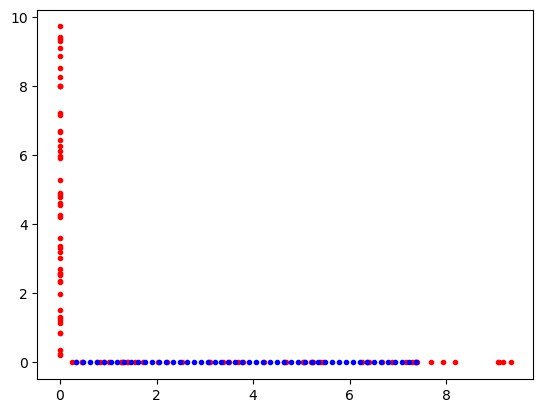

In [38]:
plt.plot( ll[:,0], ll[:,1], "r." )
plt.plot( p[:,0], p[:,1], "b." );

<span style="color:green">
Нашли чуть более удаленные точки.
</span>

<span style="color:green"> 
Теперь вычислим расстояние от всех точек до найденной прямой и разобьем
  точки на 2 множества.
</span>

In [39]:
dis = np.abs( np.cross(p2-p1,ll-p1)/np.linalg.norm(p2-p1) )

In [40]:
n1 = ll[ dis < 0.15 ]

In [41]:
o1 = ll[ np.logical_not(dis < 0.15) ]

Отделили найденные точки лежащие на прямой от остальных.

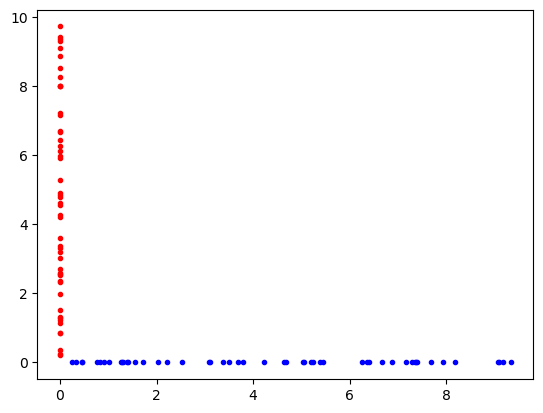

In [42]:
plt.plot( n1[:,0], n1[:,1], "b." )
plt.plot( o1[:,0], o1[:,1], "r." );

<span style="color:green"> 
    В случае когда прямых больше, чем 2, отбрасываем уже найденные множества точек
    (прямые). 
</span>
С оставшимися точками необходимо провести аналогичную процедуру.
И так пока все точки не будут обработаны.

<span style="color:green"> 
    В рассмотренном случае не было шума. Добавим его.
</span>

<h3>Облако точек вдоль отрезка</h3>

<b>Облако точек вдоль отрезка</b>

Сформируем датасет большего размера.

In [43]:
rr = rng.random( 50 ) #np.random.rand( 50 )
ll = rng.standard_normal( 50 )/100 # np.random.randn( 50 )/100

In [44]:
np.std( ll ), np.max( np.abs(ll) )

(0.008893176798098557, 0.021537110354291126)

In [45]:
dd = np.dstack( (rr, ll) )[0]

In [46]:
dd.shape

(50, 2)

In [47]:
dd[4]

array([ 0.27473804, -0.01258123])

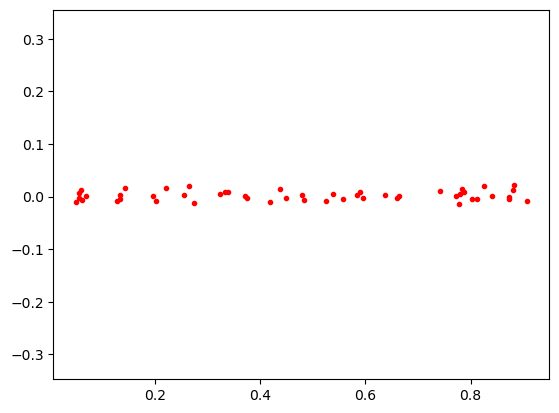

In [48]:
plt.plot( dd[:,0], dd[:,1], "r.")
plt.axis( 'equal');

Научимся его поворачивать

In [49]:
def make_rotate( deg ):
    theta = np.radians( deg )
    return np.array(( (np.cos(theta), -np.sin(theta)),
               (np.sin(theta),  np.cos(theta)) ))

In [50]:
r30 = make_rotate( 30 )

In [51]:
dd30 = r30.dot( dd.T ).T

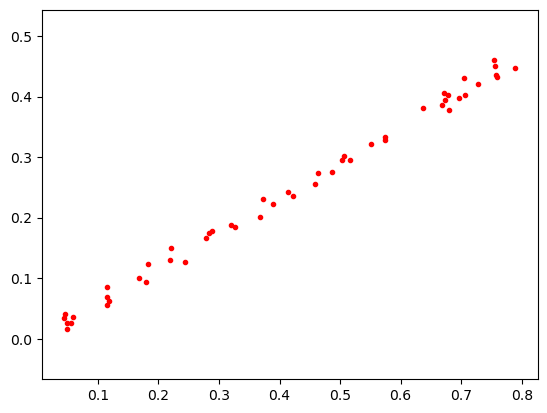

In [52]:
plt.plot( dd30[:,0], dd30[:,1], "r.")
plt.axis( 'equal');

In [53]:
def make_line( n = 50, k = 100 ):
    rr = rng.random( n ) #np.random.rand( n )
    ll = rng.standard_normal( n )/k #np.random.randn( n )/k
    return np.dstack( (rr, ll) )[0]

In [54]:
dd30 = (make_rotate( 30 ).dot( make_line().T ) ).T
rm30 = (make_rotate( -30 ).dot( make_line().T ) ).T
rm90 = (make_rotate( 90 ).dot( make_line().T ) ).T

In [55]:
rm30 = rm30 + np.array([-0.2,0.1])
dd30 = dd30 + np.array([-0.0,-0.1])
rm90 = rm90 + np.array([0.45,-0.5])

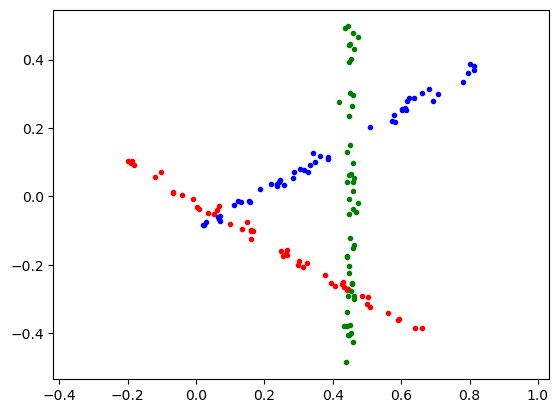

In [57]:
plt.plot( rm30[:,0], rm30[:,1], "r.")
plt.plot( dd30[:,0], dd30[:,1], "b.")
plt.plot( rm90[:,0], rm90[:,1], "g.")
plt.axis( 'equal');

<span style="color:green"> 
Множество точек: 3 прямые. Как их разделить?
</span>

In [58]:
qq = np.vstack( (dd30, rm30, rm90) )
qq.shape

(150, 2)

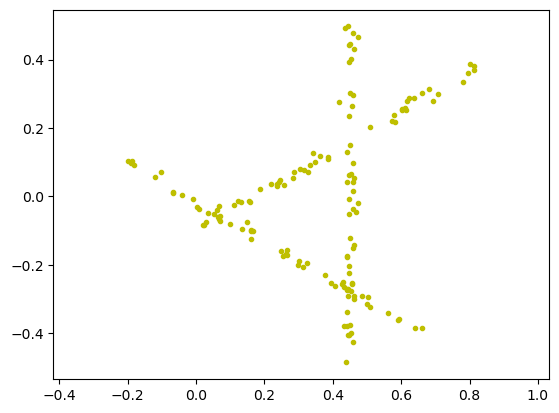

In [59]:
plt.plot( qq[:,0], qq[:,1], "y.")
plt.axis( 'equal');

<b>Найдем отрезки</b>

Фактически восстановим отрезки. 
<span style="color:green"> 
Используем функцию "search_4_line", определенную выше.
</span>

In [60]:
ii, jj = search_4_line( qq, dist = 0.015 )

In [61]:
ii, jj

(92, 62)

In [62]:
pp = qq[ [ii,jj] ]
pp.shape

(2, 2)

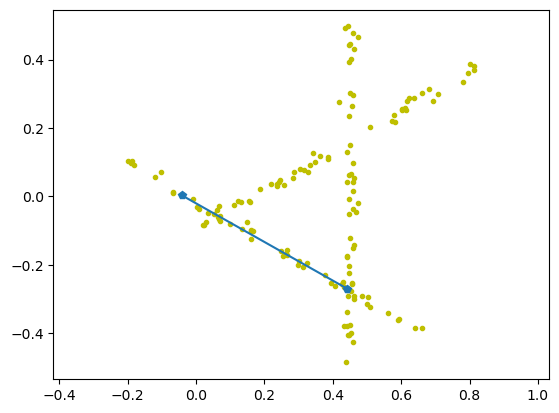

In [63]:
plt.plot( qq[:,0], qq[:,1], "y.")
plt.plot( pp[:,0], pp[:,1], "p-")
plt.axis( 'equal');

<span style="color:green"> 
Расширим отрезок:
</span>

In [64]:
ii, jj = refine_points( qq, ii, jj, dist = 0.02)

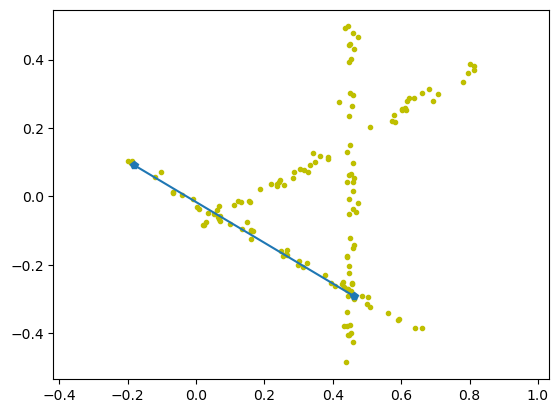

In [66]:
pp = qq[ [ii,jj] ]
plt.plot( qq[:,0], qq[:,1], "y.")
plt.plot( pp[:,0], pp[:,1], "p-")
plt.axis( 'equal');

<span style="color:green"> 
Отдельно выведем найденные точки:
</span>

In [67]:
p2, p1 = qq[ [ii,jj] ]
dis = np.abs( np.cross(p2-p1,qq-p1)/np.linalg.norm(p2-p1) )
qqq = qq[ dis < 0.02 ]

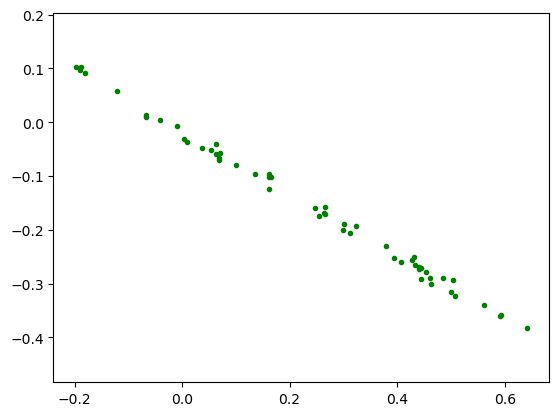

In [68]:
plt.plot( qqq[:,0], qqq[:,1], "g.")
plt.axis( 'equal');

<span style="color:green"> 
Через данное множество точек проведем наилучшую прямую с помощью метода PCA.
</span>

In [69]:
from sklearn.decomposition import PCA

In [70]:
pca = PCA(2, random_state = 2021)

In [71]:
pca.fit( qqq )

PCA(n_components=2, random_state=2021)

In [72]:
pca.components_

array([[-0.86559379,  0.50074683],
       [ 0.50074683,  0.86559379]])

In [73]:
pca.mean_

array([ 0.23701257, -0.15482699])

In [74]:
np.mean(qqq[:,0] )

0.2370125730818374

In [75]:
np.mean(qqq[:,1] )

-0.15482699049409446

In [76]:
k = -0.86559379/0.50074683
k

-1.7286056309133302

In [77]:
l = lambda x: k*(x - np.mean(qqq[:,1] )) + np.mean(qqq[:,0] )

In [78]:
ll = np.linspace( -0.42, 0.12, 20)

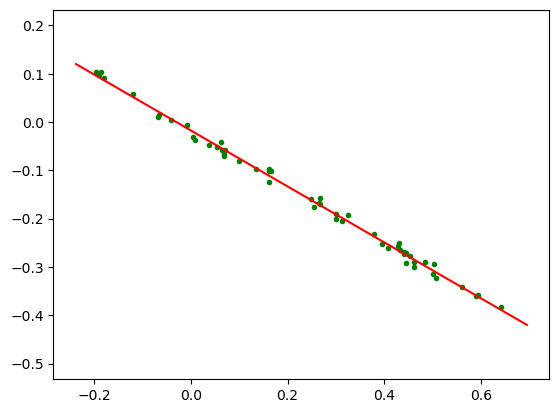

In [79]:
plt.plot( qqq[:,0], qqq[:,1], "g.")
plt.plot( l(ll), ll, 'r-')
plt.axis( 'equal');

<span style="color:green"> 
Затем удаляем это множество точек из "треугольника" выше и запускаем 
алгоритм для оставшихся точек.
</span>

<h3>Поиск плоскости</h3>

<span style="color:green"> 
На предыдущей лекции мы научились строить облако точек по фотографии.    
Пусть мы хотим провести плоскость через это облако точек. Плоскость задается 3 точками. Будем действовать аналогично, выбирая
 уже 3 случайные точки.
Получаем алгоритм векторизации облака точек. 
</span>

<span style="color:green"> 
Построим случайные множества точек на плоскости:
</span>

In [80]:
plane1 = np.dstack( [ rng.random(30), rng.random(30)] )[0] # np.random.rand(30), np.random.rand(30)
plane1.shape

(30, 2)

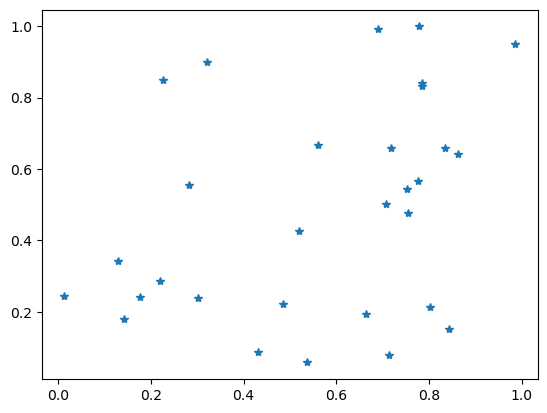

In [81]:
plt.plot( plane1[:,0], plane1[:,1], "*" );

In [82]:
nz1 = np.random.randn( plane1.shape[0] )/100
nz1.shape

(30,)

In [83]:
plane1 = np.append( plane1, np.array([nz1]).T, axis=1)
plane1.shape

(30, 3)

In [84]:
plane2 = np.dstack( [np.random.rand(30), np.random.rand(30)] )[0]
nz2 = np.random.randn( plane1.shape[0] )/100
plane2 = np.append( plane2, np.array([nz2]).T, axis=1)

In [85]:
plane2.shape

(30, 3)

<span style="color:green"> 
Сделаем повороты плоскостей вокруг различных осей с помощью "from_rotvec":
</span>

In [86]:
R = transform.Rotation.from_rotvec( [0,1,1] )
R

In [87]:
plane1_ = R.apply( plane1 )

In [88]:
R = transform.Rotation.from_rotvec( [0.5,0.5,0] )
plane2_ = R.apply( plane2 )

In [89]:
np.max( plane1_ ), np.min( plane1_ )

(1.237771951832705, -0.5956059630168918)

In [90]:
np.max( plane2_ ), np.min( plane2_ )

(0.9464722808711331, -0.3168891558943132)

In [91]:
# %matplotlib widget

In [89]:
%matplotlib

Using matplotlib backend: Qt5Agg


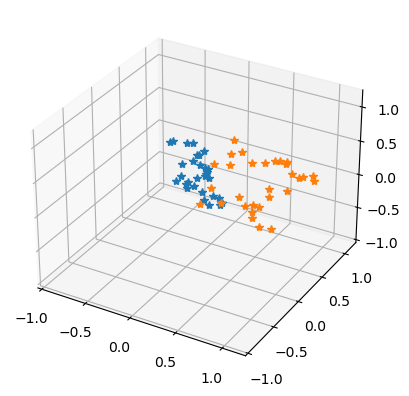

In [92]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot3D( plane1_[:,0], plane1_[:,1], plane1_[:,2], '*')
ax.plot3D( plane2_[:,0], plane2_[:,1], plane2_[:,2], '*')

ax.set_xlim3d(-1., 1.2)
ax.set_ylim3d(-1., 1.2)
ax.set_zlim3d(-1., 1.2);

<span style="color:green"> 
Построили 2 пересекающиеся плоскости.
</span>

In [93]:
planes = np.vstack( [plane1_, plane2_] )

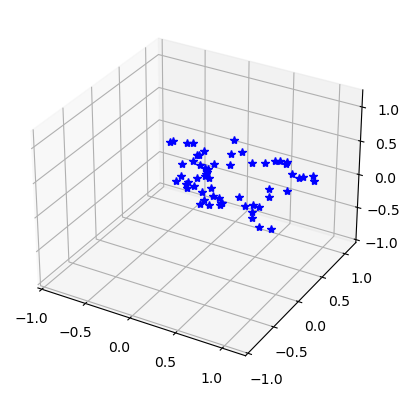

In [94]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot3D( planes[:,0], planes[:,1], planes[:,2], 'b*')

ax.set_xlim3d(-1., 1.2)
ax.set_ylim3d(-1., 1.2)
ax.set_zlim3d(-1., 1.2);

In [95]:
planes.shape

(60, 3)

<span style="color:green"> 
Запускаем аналогичный алгоритм, выбирающий по 3 точки:
</span>

In [96]:
rraa = 0
for _ in range(10000):
    i = rng.integers(60) # np.random.randint( 60 )
    j = rng.integers(60) # np.random.randint( 60 )
    k = rng.integers(60) # np.random.randint( 60 )
    if i == j or i == k or j == k:
        continue
    p1 = planes[i]
    p2 = planes[j]
    p3 = planes[k]
    v1 = p2 - p1
    v2 = p3 - p1
    abc = np.cross( v1, v2 )# ax+by+cz+d=0
    abc /= np.sqrt( np.sum(abc**2) )
    d = -np.dot( abc, p3)
    ss = 0.
    for z in range(60):
        if z in [i,j,k]:
            continue
        #print( d )
        ss += (np.abs((np.dot( abc, planes[ z ] ) + d)) < 0.01)
    #print( ss )
    if rraa < ss:
        rraa = ss
        ii = i
        jj = j
        kk = k

In [97]:
rraa

20.0

In [98]:
ii, jj, kk

(28, 1, 10)

In [99]:
i, j, k = 19, 18, 6
p1 = planes[i]
p2 = planes[j]
p3 = planes[k]
v1 = p2 - p1
v2 = p3 - p1
abc = np.cross( v1, v2 )
abc /= np.sqrt( np.sum(abc**2)  )
d = -np.dot( abc, p3)
print(d)
ss = 0.
qsx = np.zeros( 60 )
for z in range(60):
    #if z in [i,j,k]:
    #    continue
    #print( d )
    if np.abs((np.dot( abc, planes[ z ] ) + d)) < 0.05:
        qsx[z] = 1

-0.28650367391652276


In [100]:
qsx

array([0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1.,
       0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0.])

In [101]:
np.sum(qsx)

16.0

In [102]:
qsx = np.array( qsx  )

In [103]:
pn = planes[ qsx == 1]

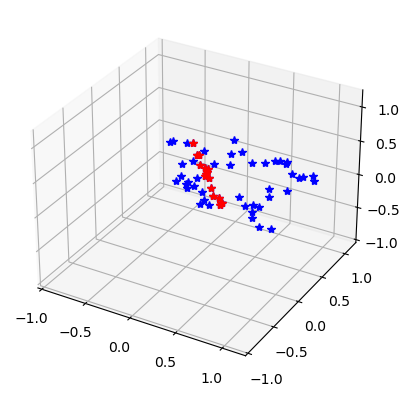

In [104]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot3D( planes[:,0], planes[:,1], planes[:,2], 'b*')
ax.plot3D( pn[:,0], pn[:,1], pn[:,2], 'r*')

ax.set_xlim3d(-1., 1.2)
ax.set_ylim3d(-1., 1.2)
ax.set_zlim3d(-1., 1.2);

<span style="color:green"> 
    Выделили точки, принадлежащие одной из плоскостей.
</span>

In [105]:
%matplotlib inline